This starts from the [msdexample.ipynb](https://nbviewer.jupyter.org/url/research.edm.uhasselt.be/~jori/grale2/_static/msdexample.ipynb) notebook,
and illustrates the idea how extrapolation of lens potential values can be used to generate lenses that
behave similarly to a mass sheet, to be used in the mass sheet degeneracy (MSD) construction.

In [1]:
%matplotlib inline

In [2]:
# Import some modules and set some defaults
from grale.all_nb import *
feedback.setDefaultFeedback("none")
LI = plotutil.LensInfo

Set 'threads' as default renderer for lensplane and mass density
Set default angular unit in plotting to arcsec
Set feedback style to 'notebook'


In [3]:
# The cosmological model we're going to use
cosm = cosmology.Cosmology(0.7,0.3,0,0.7)

In [4]:
# Set redshifts and calculate angular diameter distances
z_d, z_s = 0.5, 2.0
Dd = cosm.getAngularDiameterDistance(z_d)
Dds = cosm.getAngularDiameterDistance(z_d, z_s)
Ds = cosm.getAngularDiameterDistance(z_s)

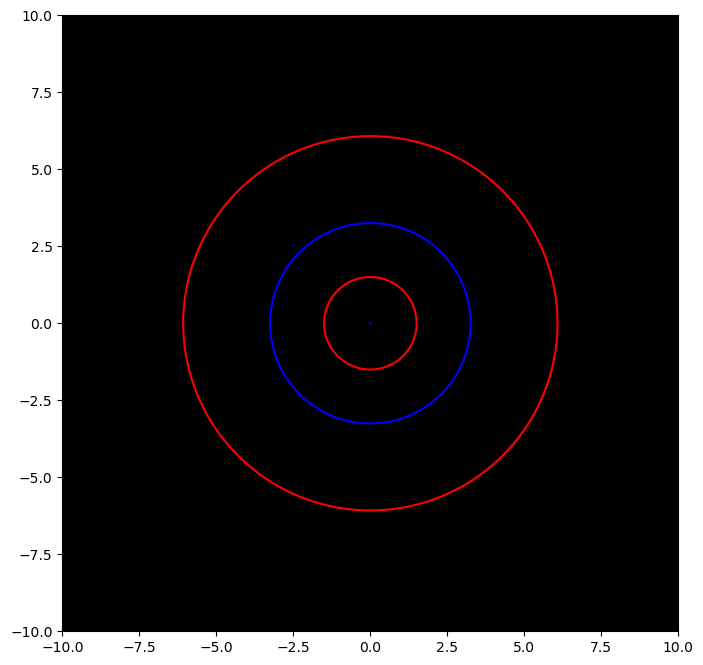

In [5]:
# As the base lens we're going to use a NSIS lens; below we'll create a
# mass sheet degenerate (MSD) version based on this model
baseLens = lenses.NSISLens(Dd, {"velocityDispersion": 600000, "coreRadius": 0.5*ANGLE_ARCSEC})
lensInfo = LI(baseLens, size=20*ANGLE_ARCSEC, Ds=Ds, Dds=Dds)
    
plotutil.plotDensityInteractive(lensInfo, visJSoptions= { "zMin": 0});
plt.figure(figsize=(8,8))
plotutil.plotImagePlane(lensInfo);

In [6]:
# Calculate the critical density for a source at the specified redshift
critDens = lensInfo.getLens().getCriticalDensity(Ds, Dds)
print("Critical density:", critDens, "kg/m^2")

Critical density: 4.341745756808096 kg/m^2


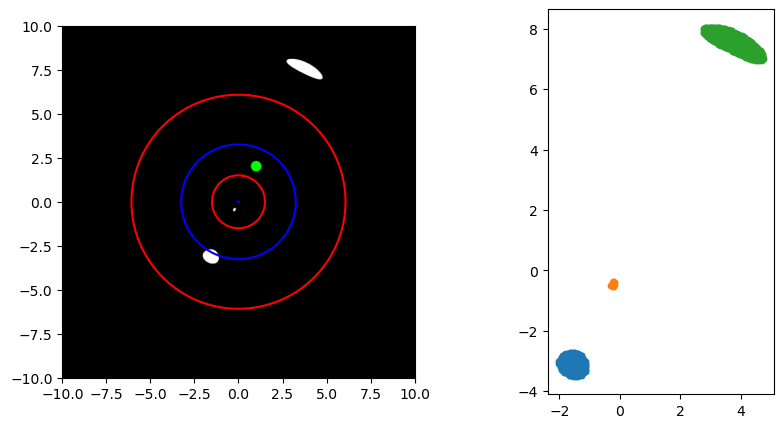

In [7]:
# For a certain source position, show the images and create an ImagesData instance with these
# image points. This ImagesData instance will be needed in the function that creates an
# lens equivalent to the mass sheet, since we want the effect at the image positions to be
# the same.

origPos, origSize = V(1,2)*ANGLE_ARCSEC, 0.3*ANGLE_ARCSEC

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plotutil.plotImagePlane(lensInfo, [images.CircularSource(origPos, origSize)]);

ip = lensInfo.getImagePlane()
imgPixels = ip.segment(ip.renderImages([images.CircularSource(origPos, origSize)]))
imgDat = images.ImagesData(len(imgPixels))
for idx, img in enumerate(imgPixels):
    for pt in img:
        imgDat.addPoint(idx, pt)
        
plt.subplot(1,2,2)
plotutil.plotImagesData(imgDat)
plt.gca().set_aspect("equal")

In [8]:
# This subroutine eventually will call "createEquivalentPotentialGridLens" that will start
# from the lens potential values at the image positions, and extrapolate them outward.
# To investigate how certain settings affect the result, they can be specified as parameters
# to the createEquivMassSheetLens function:
#  - potentialGradientWeight: in the extrapolation function, several weights can be specified.
#    The one for the density gradient is fixed to 1, the one for the density itself is fixed to
#    0, and this parameter sets the remaining weight for the gradient of the lens potential
#  - contraintType: the border pixels of the 128x128 grid can be used to set some constraints,
#    where "none" specifies that no constraint is to be used. "exact" means that these border
#    pixels should have an exact density, specified by 'constraintValue'. "max" means that their
#    resulting density value should be less than 'constraintValue', and "min" means that their
#    density should be more than 'constraintValue'.

sheet = lenses.MassSheetLens(Dd, { "density": critDens })

def createEquivMassSheetLens(potentialGradientWeight, constraintType, constraintValue):
    
    HW, N = 20, 128
    tr = V(HW,HW)*ANGLE_ARCSEC
    bl = -tr

    BW = 10
    border = np.zeros((N,N),dtype=bool)
    border[:BW,:] = True
    border[-BW:,:] = True
    border[:,:BW] = True
    border[:,-BW:] = True

    exactDensConstr, maxDensConstr = [], []
    if constraintType == "exact":
        exactDensConstr = [ { "density": constraintValue, "maskRegions": [ border ] } ]
    elif constraintType == "max":
        maxDensConstr = [ { "density": constraintValue, "maskRegions": [ border ], "upperlimit": True } ]
    elif constraintType == "min":
        maxDensConstr = [ { "density": constraintValue, "maskRegions": [ border ], "upperlimit": False } ]
    elif constraintType == "none":
        pass
    else:
        raise Exception("Invalid constraint type")

    r = lenses.createEquivalentPotentialGridLens(sheet, bl, tr, N, N,
                                                     [imgDat],
                                                     potentialGradientWeight=potentialGradientWeight,
                                                     densityGradientWeight=1.0,
                                                     densityWeight=0.0,
                                                     feedbackObject="stdout",
                                                     exactDensityConstraints=exactDensConstr,
                                                     maxDensityConstraints=maxDensConstr,
                                                     #ignorePositiveDensityConstraint=True,
                                                     pixelEnlargements=4,
                                                     qpsolver="mosek")
    
    
    return r["philens_equiv"]

In [9]:
# Helper function to show the results
def plotInteractive(l):
    plotutil.plotDensityInteractive(LI(l, size=35*ANGLE_ARCSEC), visJSoptions={"zMin": 0})

In [10]:
# This is the sheet itself, just as a reference
plotInteractive(sheet)

In [11]:
# For a very low weight of the potential gradient, the density gradient constraint
# essentially leads to a mass sheet again
eqFlat = createEquivMassSheetLens(0.000001, "none", 0)
plotInteractive(eqFlat)

STATUS: Calculating lens potential values
STATUS: Calculating linear constraints
STATUS: Calculating quadratic optimization matrices
STATUS: Solving quadratic programming problem
STATUS: Done, in 18.7 seconds


In [12]:
# A stronger weight wants to push the potential towards a flatter one, corresponding
# to a lower mass density
eqLessFlat = createEquivMassSheetLens(0.0001, "none", 0)
plotInteractive(eqLessFlat)

STATUS: Calculating lens potential values
STATUS: Calculating linear constraints
STATUS: Calculating quadratic optimization matrices
STATUS: Solving quadratic programming problem
STATUS: Done, in 19.5 seconds


In [13]:
# We can ask for an exact constraint on the density in the border pixels. Here we set it to 0
eqExact = createEquivMassSheetLens(0.0001, "exact", 0.0)
plotInteractive(eqExact)

STATUS: Calculating lens potential values
STATUS: Calculating linear constraints
STATUS: Calculating quadratic optimization matrices
STATUS: Solving quadratic programming problem
STATUS: Done, in 19.4 seconds


In [14]:
# Or set a maximum value in that region
eqMax = createEquivMassSheetLens(0.0001, "max", 1.25)
plotInteractive(eqMax)

STATUS: Calculating lens potential values
STATUS: Calculating linear constraints
STATUS: Calculating quadratic optimization matrices
STATUS: Solving quadratic programming problem
STATUS: Done, in 19.2 seconds


In [15]:
# Or set a minimum value in that region
eqMin = createEquivMassSheetLens(0.0001, "min", 1.25)
plotInteractive(eqMin)

STATUS: Calculating lens potential values
STATUS: Calculating linear constraints
STATUS: Calculating quadratic optimization matrices
STATUS: Solving quadratic programming problem
STATUS: Done, in 17.3 seconds


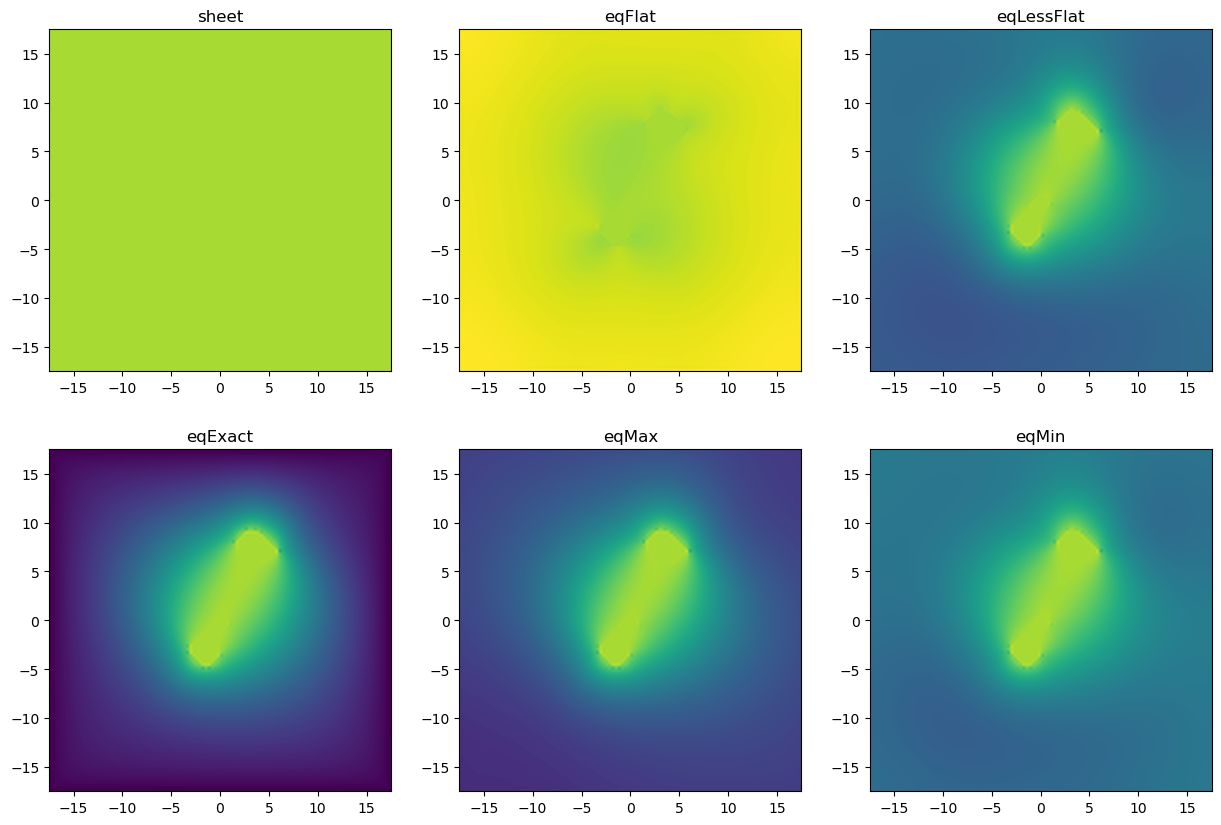

In [16]:
# These are the mass densities of each of these lenses with a sheet-like
# effect (for these images)
equivSheetLenses = [ sheet, eqFlat, eqLessFlat, eqExact, eqMax, eqMin ]
lensNames = [ "sheet", "eqFlat", "eqLessFlat", "eqExact", "eqMax", "eqMin" ]

plt.figure(figsize=(15,10))
for idx, l in enumerate(equivSheetLenses):
    plt.subplot(2,3,idx+1)
    plt.title(lensNames[idx])
    plotutil.plotDensity(plotutil.LensInfo(l, size=35*ANGLE_ARCSEC), vmin=0, vmax=5)

In [17]:
# Perform an MSD like construction
_lambda = 0.7

msdLenses = []
for equivSheet in equivSheetLenses:
    msd = lenses.CompositeLens(Dd, [
        { "factor": _lambda, "x": 0, "y": 0, "angle": 0, "lens": baseLens },
        { "factor": (1-_lambda), "x": 0, "y": 0, "angle": 0, "lens": equivSheet }
    ])
    msdLenses.append(msd)    

In [18]:
# An equivalent source position/size is then also a rescaled version of the starting values
newPos, newSize = origPos*_lambda, origSize*_lambda

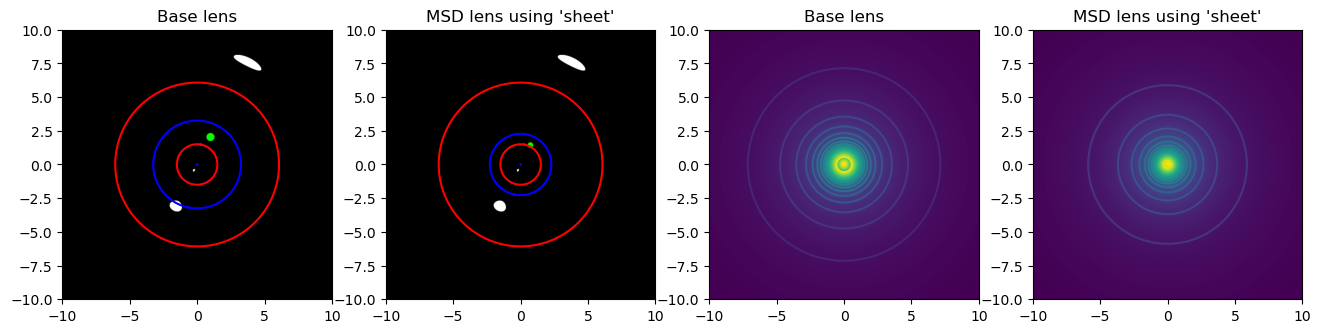

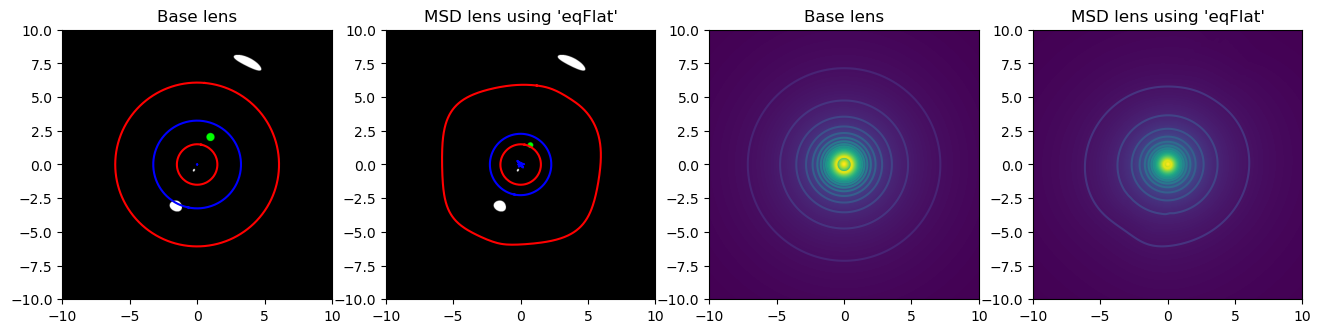

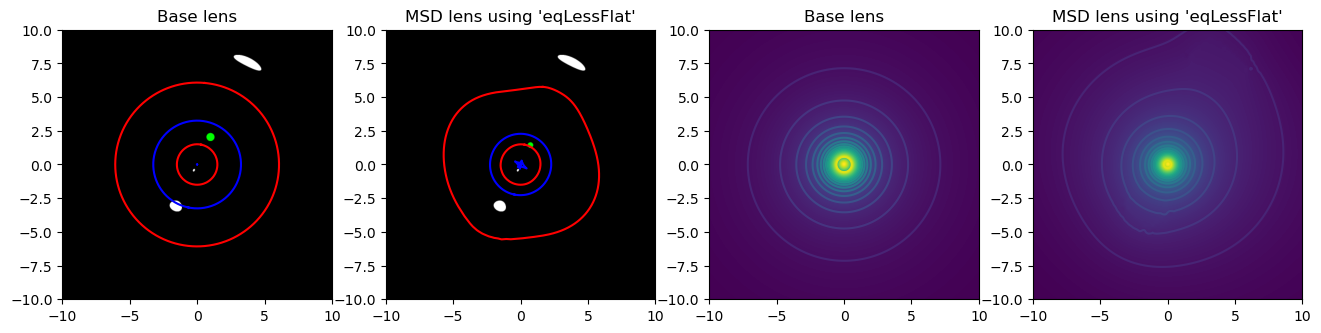

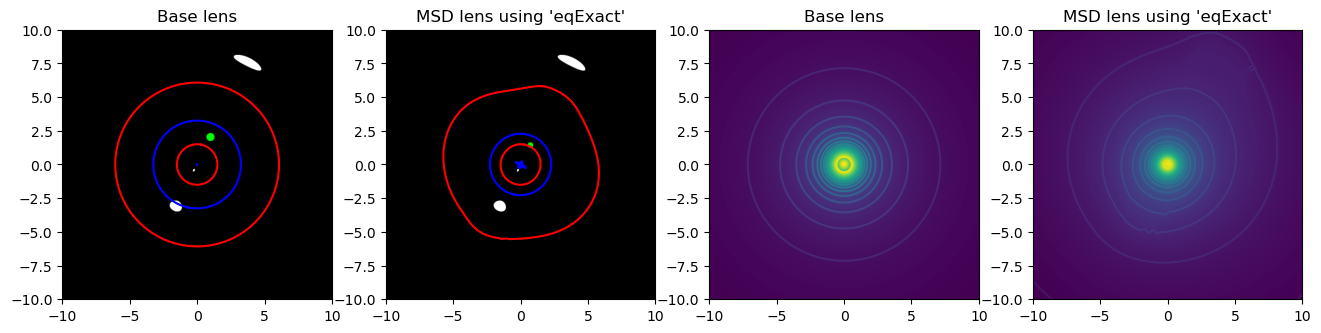

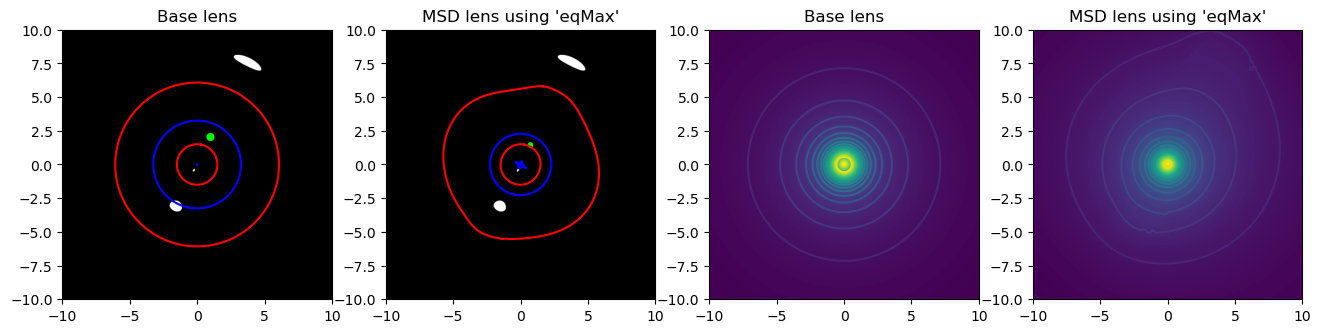

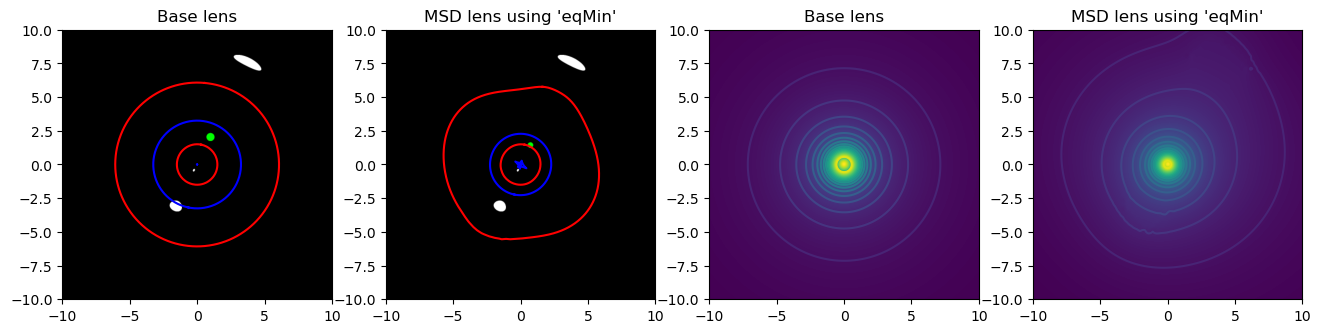

In [19]:
# Show lens planes and mass densities for each degenerate version, comparing it each
# time to the base lens
for idx, msd in enumerate(msdLenses):
    msdLensInfo = LI(msd, size=20*ANGLE_ARCSEC, Ds=Ds, Dds=Dds)
    name = lensNames[idx]
    
    plt.figure(figsize=(16,4))
    plt.subplot(1,4,1)
    plt.title("Base lens")
    plotutil.plotImagePlane(lensInfo, [images.CircularSource(origPos, origSize)]);
    plt.subplot(1,4,2)
    plt.title(f"MSD lens using '{name}'")
    plotutil.plotImagePlane(msdLensInfo, [images.CircularSource(newPos, newSize)]);
    plt.subplot(1,4,3)
    plt.title("Base lens")
    plotutil.plotDensity(lensInfo)
    plotutil.plotDensityContours(lensInfo, levels=np.arange(0, 20, 1), vmin=0, vmax=20)
    plt.subplot(1,4,4)
    plt.title(f"MSD lens using '{name}'")
    plotutil.plotDensity(msdLensInfo)
    plotutil.plotDensityContours(msdLensInfo, levels=np.arange(0, 20, 1), vmin=0, vmax=20)


In [20]:
# Get the radii at which images occur, we'll use these in a plot below
imgRadii = []
for idx in range(imgDat.getNumberOfImages()):
    pts = np.array([ p["position"] for p in imgDat.getImagePoints(idx) ])/ANGLE_ARCSEC
    pts = np.sum(pts**2, axis=1)**0.5
    pts = pts.reshape((-1,1))
    
    imgRadii.append(pts)
imgRadii = np.vstack(imgRadii).reshape((-1,))

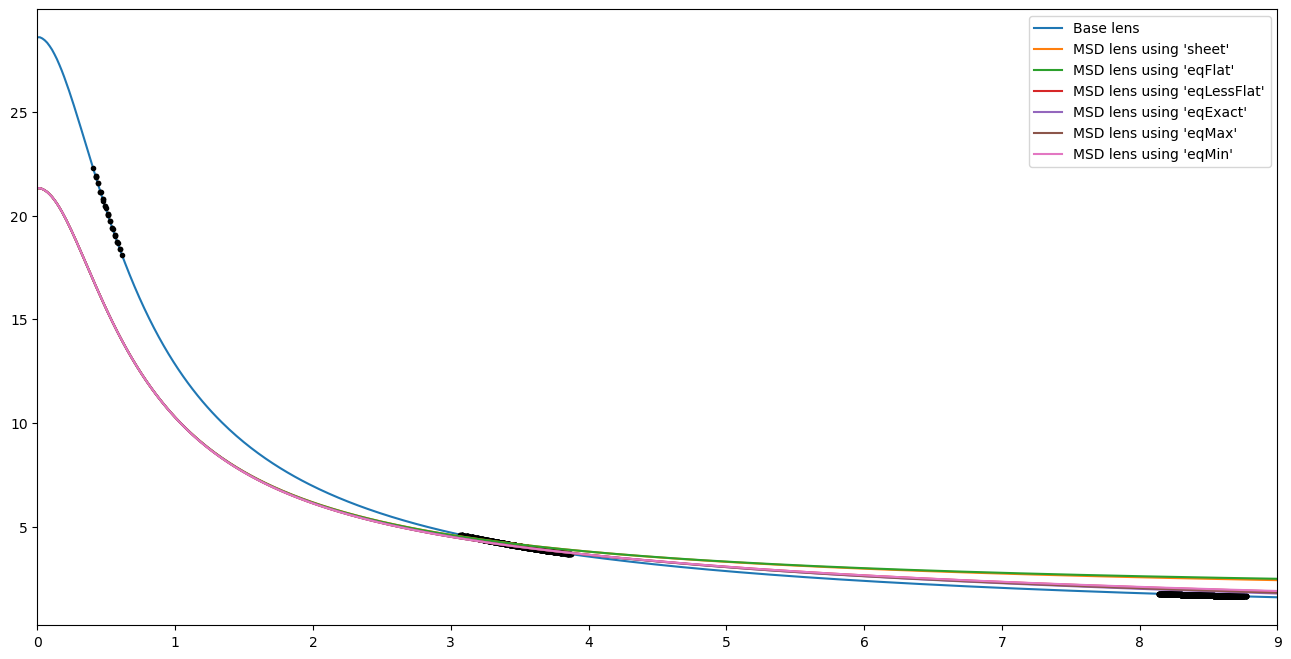

In [21]:
# To better visualize the rescaling of the mass density and addition of a
# sheet of mass, we'll also plot the circularly averaged profiles for the base
# lens as well as for the MSD lenses

plt.figure(figsize=(16,8))

baseProf = plotutil.plotAverageDensityProfile(lensInfo, thetaMax = 9*ANGLE_ARCSEC, label="Base lens")
baseDensities = np.interp(imgRadii, baseProf[0]/ANGLE_ARCSEC, baseProf[1])
plt.plot(imgRadii, baseDensities, '.', color='black')

for idx, equivSheet in enumerate(equivSheetLenses):
    msdLensInfo = LI(msdLenses[idx], size=20*ANGLE_ARCSEC, Ds=Ds, Dds=Dds)
    name = lensNames[idx]
    
    plotutil.plotAverageDensityProfile(msdLensInfo, thetaMax = 9*ANGLE_ARCSEC, label=f"MSD lens using '{name}'");
    
plt.legend()
plt.gca().set_xlim([0,9]);

In [22]:
# While all lenses show the same different density slope in the inner region, the size of the
# offset in the outer region differs. In fact, for the 'eqExact' version, it does not differ than
# much from the base lens.